# Herron Topic 6 - Practice (Monday 2:45 PM, Section 3)

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple, Dict
import yfinance as yf
import pandas_datareader as pdr
import requests_cache
import statsmodels.formula.api as smf
import seaborn as sns
from pathlib import Path
session = requests_cache.CachedSession()

In [2]:
%config InlineBackend.figure_format = 'retina'
%precision 4
pd.options.display.float_format = '{:.4f}'.format

In [3]:
def analyze_investment_strategies(crsp_path: str, start_year: str = '1900') -> Dict:
    """
    Analyzes momentum and size-based investment strategies using CRSP data.
    
    Parameters:
    -----------
    crsp_path : str
        Path to the CRSP CSV file
    start_year : str
        Start year for Fama-French factors data
        
    Returns:
    --------
    Dict containing DataFrames with analysis results and figures
    """
    
    # Helper functions
    def capm(df, c):
        return smf.ols(formula=f'I(Q("{c}")-RF) ~ Q("Mkt-RF")', data=df)
    
    def ff4(df, c):
        return smf.ols(formula=f'I(Q("{c}")-RF) ~ Q("Mkt-RF") + SMB + HML + Mom', data=df)
    
    def sharpe(r, tgt, ppy):
        er = r.sub(tgt).dropna()
        return np.sqrt(ppy) * er.mean() / er.std()
    
    def get_coefs(df, fun, n):
        models = [df.pipe(fun, c) for c in df.columns[:n]]
        fits = [m.fit() for m in models]
        coefs = pd.concat([f.params for f in fits], axis=1, keys=df.columns[:10]).transpose()
        coefs.index.name = 'Portfolio'
        coefs.columns.name = 'Variable'
        
        ses = pd.concat([f.bse for f in fits], axis=1, keys=df.columns[:10]).transpose()
        ses.index.name = 'Portfolio'
        ses.columns.name = 'Variable'
        
        return pd.concat([coefs, ses], keys=['Coef', 'SE'], names=['Statistic'], axis=1)
    
    def plot_alpha(df, title):
        _ = df.swaplevel(axis=1)['Intercept']
        fig, ax = plt.subplots(figsize=(10, 6))
        _['Coef'].plot(kind='bar', yerr=_['SE'], ax=ax)
        plt.ylabel('Monthly Alpha (%)')
        plt.title(title)
        return fig
    
    # Load and prepare data
    session = requests_cache.CachedSession()
    
    crsp = (
        pd.read_csv(
            filepath_or_buffer=crsp_path,
            parse_dates=['date'],
            na_values=['A', 'B', 'C']
        )
        .assign(
            date=lambda x: x['date'].dt.to_period(freq='M'),
            ME=lambda x: x['PRC'].abs() * x['SHROUT']
        )
        .rename_axis(columns='Variable')
        .set_index(['PERMNO', 'date'])
    )
    
    # Calculate returns
    ret_1m = crsp['RET'].unstack('PERMNO')
    ret_11m = ret_1m.pipe(np.log1p).rolling(11).sum().pipe(np.expm1)
    port_11m = ret_11m.dropna(how='all').apply(pd.qcut, q=10, labels=False, axis=1)
    
    # Momentum strategy calculations
    mom = pd.concat([
        ret_1m,
        ret_11m.shift(2),
        port_11m.shift(2),
        crsp['ME'].unstack('PERMNO').shift(1)
    ],
    keys=['Return', 'Trailing Return', 'Portfolio', 'Trailing ME'],
    names=['Variable'],
    axis=1).stack('PERMNO').dropna().assign(Portfolio=lambda x: x['Portfolio'].astype(int) + 1)
    
    # Equal-weighted momentum
    mom_ew = (mom.groupby(['date', 'Portfolio'])['Return'].mean()
              .unstack('Portfolio')
              .add_prefix('Mom '))
    mom_ew = mom_ew.assign(UMD=lambda x: x['Mom 10'] - x['Mom 1'])
    
    # Value-weighted momentum
    mom_vw = (mom.groupby(['date', 'Portfolio'])
              .apply(lambda x: np.average(a=x['Return'], weights=x['Trailing ME']))
              .unstack('Portfolio')
              .add_prefix('Mom '))
    
    # Size strategy calculations
    me_june = crsp['ME'].unstack('PERMNO').pipe(lambda x: x.loc[x.index.month == 6])
    me = pd.concat([
        ret_1m,
        crsp['ME'].unstack('PERMNO').shift(1),
        me_june.apply(pd.qcut, q=10, labels=False, axis=1)
            .shift(freq='1M')
            .resample('M')
            .ffill(limit=12)
    ],
    keys=['Return', 'Trailing ME', 'Portfolio'],
    names=['Variable'],
    axis=1).stack('PERMNO').dropna().assign(Portfolio=lambda x: x['Portfolio'].astype(int) + 1)
    
    # Equal-weighted size
    me_ew = (me.groupby(['date', 'Portfolio'])['Return']
             .mean()
             .unstack('Portfolio')
             .add_prefix('ME '))
    
    # Value-weighted size
    me_vw = (me.groupby(['date', 'Portfolio'])
             .apply(lambda x: np.average(a=x['Return'], weights=x['Trailing ME']))
             .unstack('Portfolio')
             .add_prefix('ME '))
    
    # Get Fama-French factors
    ff_0 = pdr.DataReader('F-F_Research_Data_Factors', 'famafrench', start_year, session=session)
    ff_mom = pdr.DataReader('F-F_Momentum_Factor', 'famafrench', start_year, session=session)
    ff_mom[0].columns = ['Mom']
    
    # Generate analysis results
    results = {}
    
    # Momentum analysis
    results['mom_ew_capm'] = mom_ew.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10)
    results['mom_ew_ff4'] = mom_ew.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10)
    results['mom_vw_capm'] = mom_vw.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10)
    results['mom_vw_ff4'] = mom_vw.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10)
    
    # Size analysis
    results['me_ew_capm'] = me_ew.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10)
    results['me_ew_ff4'] = me_ew.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10)
    results['me_vw_capm'] = me_vw.mul(100).join(ff_0[0]).pipe(get_coefs, fun=capm, n=10)
    results['me_vw_ff4'] = me_vw.mul(100).join([ff_0[0], ff_mom[0]]).pipe(get_coefs, fun=ff4, n=10)
    
    # Generate plots
    plots = {}
    
    # Momentum strategy returns plot
    fig, ax = plt.subplots(figsize=(10, 6))
    mom_ew.mean().mul(100).plot(kind='bar', ax=ax)
    plt.ylabel('Mean Monthly Return (%)')
    plt.title('Momentum Strategy\nEqual-Weighted Portfolios\nFormed on Months -12 to -2')
    plots['mom_returns'] = fig
    
    # Momentum cumulative returns plot
    fig, ax = plt.subplots(figsize=(10, 6))
    mom_ew.add(1).cumprod().plot(ax=ax)
    plt.semilogy()
    plt.ylabel('Value of $1 Investment ($)')
    plt.title('Momentum Strategy\nEqual-Weighted Portfolios\nFormed on Months -12 to -2')
    plots['mom_cumulative'] = fig
    
    # Alpha plots
    plots['mom_ew_capm'] = plot_alpha(results['mom_ew_capm'],
        'CAPM Tests of Momentum Strategy\nEqual-Weighted Portfolios')
    plots['mom_ew_ff4'] = plot_alpha(results['mom_ew_ff4'],
        'FF4 Tests of Momentum Strategy\nEqual-Weighted Portfolios')
    plots['mom_vw_capm'] = plot_alpha(results['mom_vw_capm'],
        'CAPM Tests of Momentum Strategy\nValue-Weighted Portfolios')
    plots['mom_vw_ff4'] = plot_alpha(results['mom_vw_ff4'],
        'FF4 Tests of Momentum Strategy\nValue-Weighted Portfolios')
    plots['me_ew_capm'] = plot_alpha(results['me_ew_capm'],
        'CAPM Tests of Size Strategy\nEqual-Weighted Portfolios')
    plots['me_ew_ff4'] = plot_alpha(results['me_ew_ff4'],
        'FF4 Tests of Size Strategy\nEqual-Weighted Portfolios')
    plots['me_vw_capm'] = plot_alpha(results['me_vw_capm'],
        'CAPM Tests of Size Strategy\nValue-Weighted Portfolios')
    plots['me_vw_ff4'] = plot_alpha(results['me_vw_ff4'],
        'FF4 Tests of Size Strategy\nValue-Weighted Portfolios')
    
    # Sharpe ratio plots
    fig, ax = plt.subplots(figsize=(10, 6))
    mom_ew.mul(100).apply(sharpe, tgt=ff_0[0]['RF'], ppy=12).plot(kind='bar', ax=ax)
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratios for Momentum Strategy\nEqual-Weighted Portfolios')
    plots['mom_ew_sharpe'] = fig
    
    fig, ax = plt.subplots(figsize=(10, 6))
    mom_vw.mul(100).apply(sharpe, tgt=ff_0[0]['RF'], ppy=12).plot(kind='bar', ax=ax)
    plt.ylabel('Sharpe Ratio')
    plt.title('Sharpe Ratios for Momentum Strategy\nValue-Weighted Portfolios')
    plots['mom_vw_sharpe'] = fig
    
    return {
        'data': {
            'momentum_equal_weighted': mom_ew,
            'momentum_value_weighted': mom_vw,
            'size_equal_weighted': me_ew,
            'size_value_weighted': me_vw
        },
        'analysis': results,
        'plots': plots
    }


Momentum Strategy CAPM Analysis:
--------------------------------
Alpha (Portfolio 10): 0.7465%
Alpha t-stat: 5.86

Crisis Period Analysis (2008-2009):
-----------------------------------
       Momentum (EW)  Size (EW)
count        24.0000    24.0000
mean         -0.0173    -0.0046
std           0.0810     0.0850
min          -0.2061    -0.2023
25%          -0.0945    -0.0573
50%          -0.0041     0.0040
75%           0.0545     0.0496
max           0.0762     0.1763

Maximum Drawdowns:
-----------------
Momentum (EW)   -0.7283
Size (EW)       -0.8412
dtype: float64

Summary Statistics:
-----------------
         Mom_EW    Mom_VW   Size_EW   Size_VW
count 1152.0000 1152.0000 1153.0000 1153.0000
mean     0.0069    0.0147   -0.0144   -0.0056
std      0.0844    0.0871    0.0853    0.0794
min     -0.9125   -0.7756   -0.9667   -0.8844
25%     -0.0150   -0.0187   -0.0376   -0.0298
50%      0.0159    0.0183   -0.0027    0.0033
75%      0.0445    0.0588    0.0264    0.0326
max      0.2742

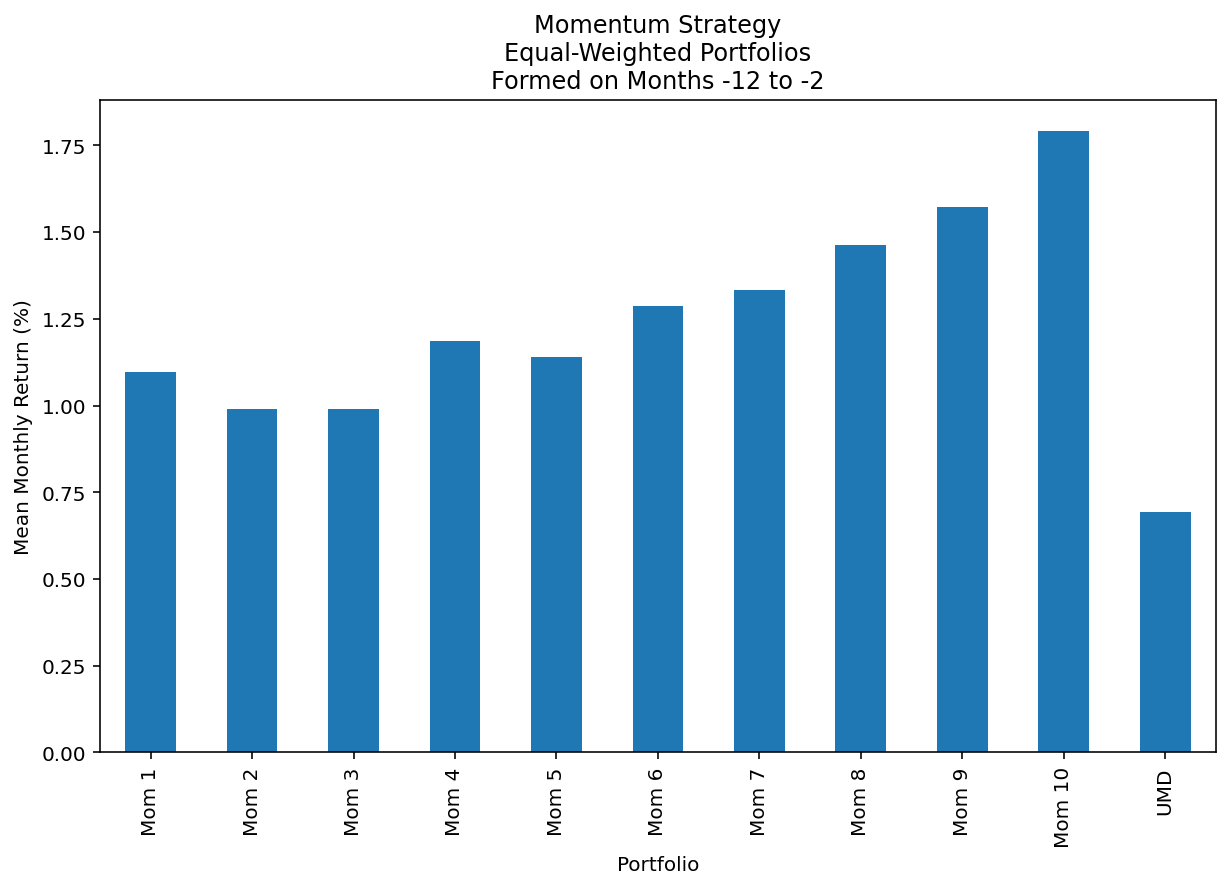

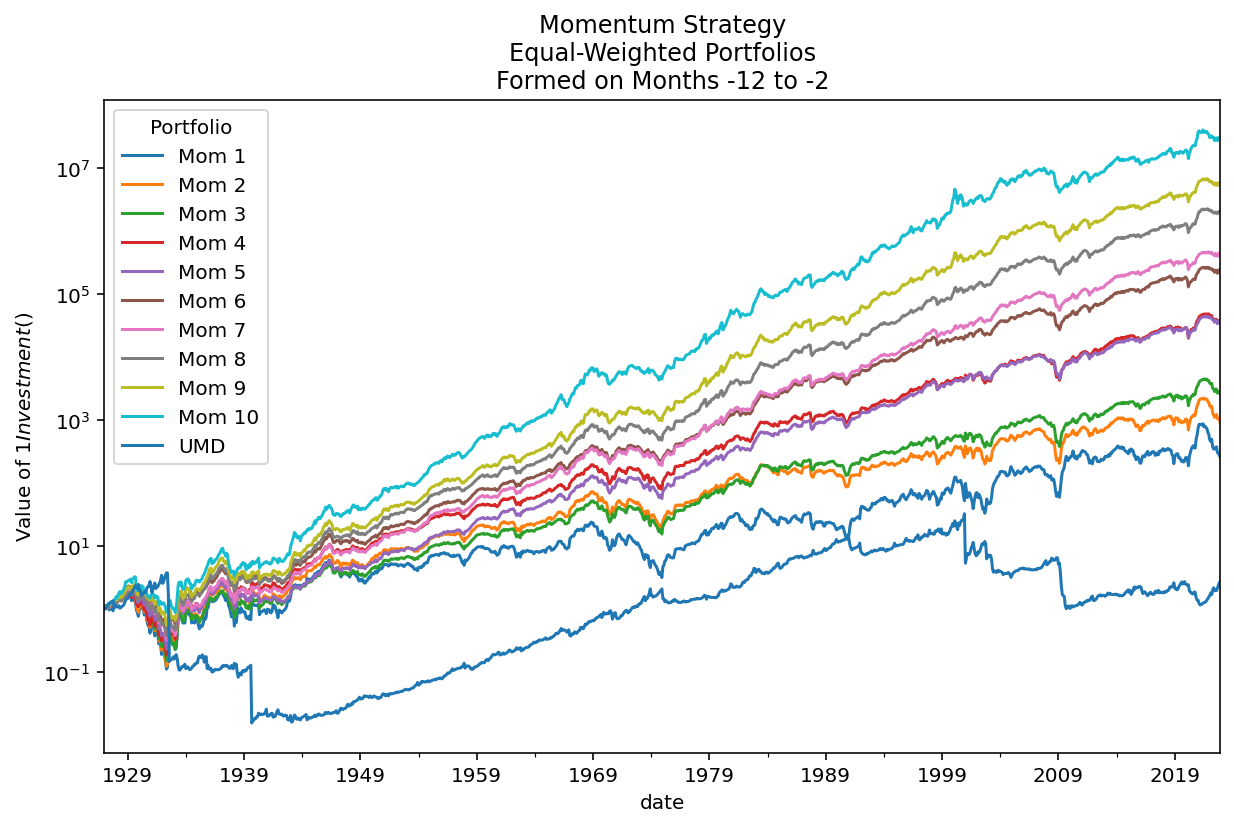

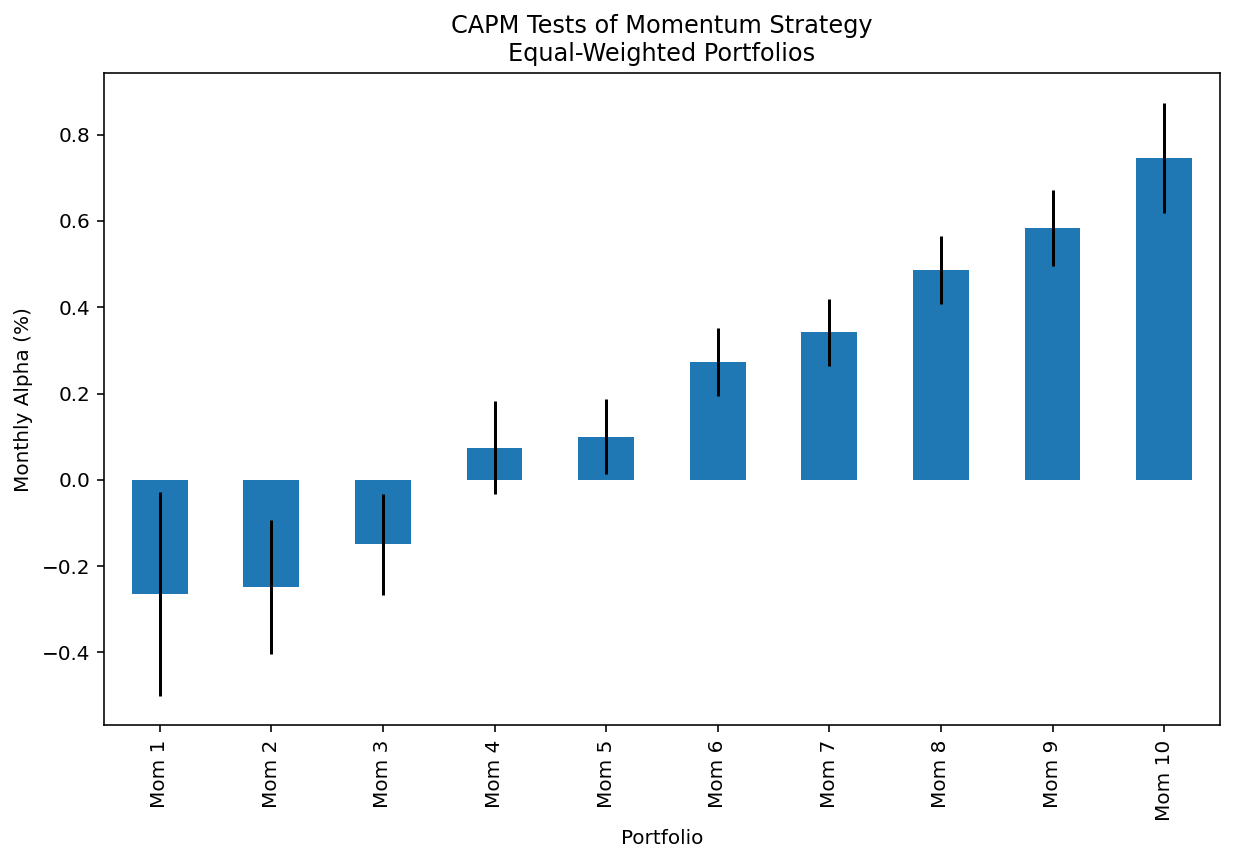

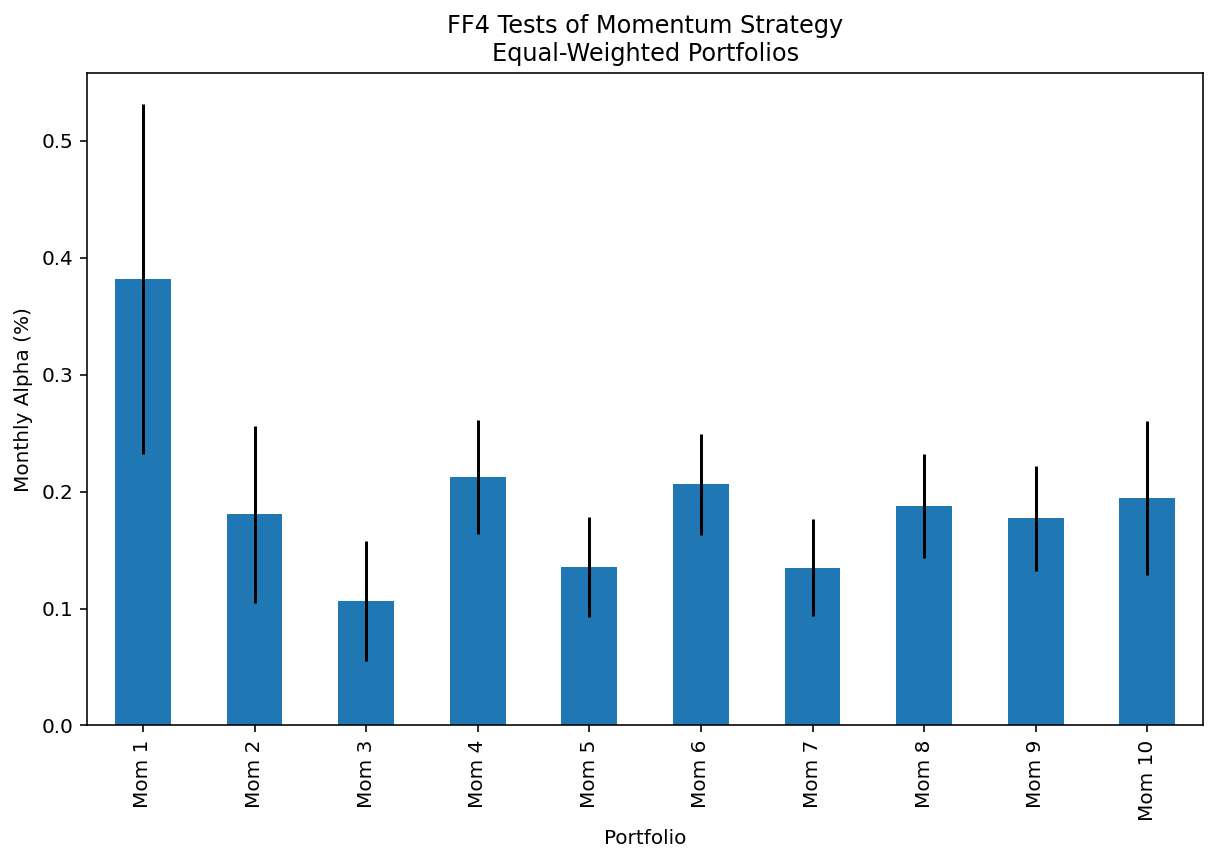

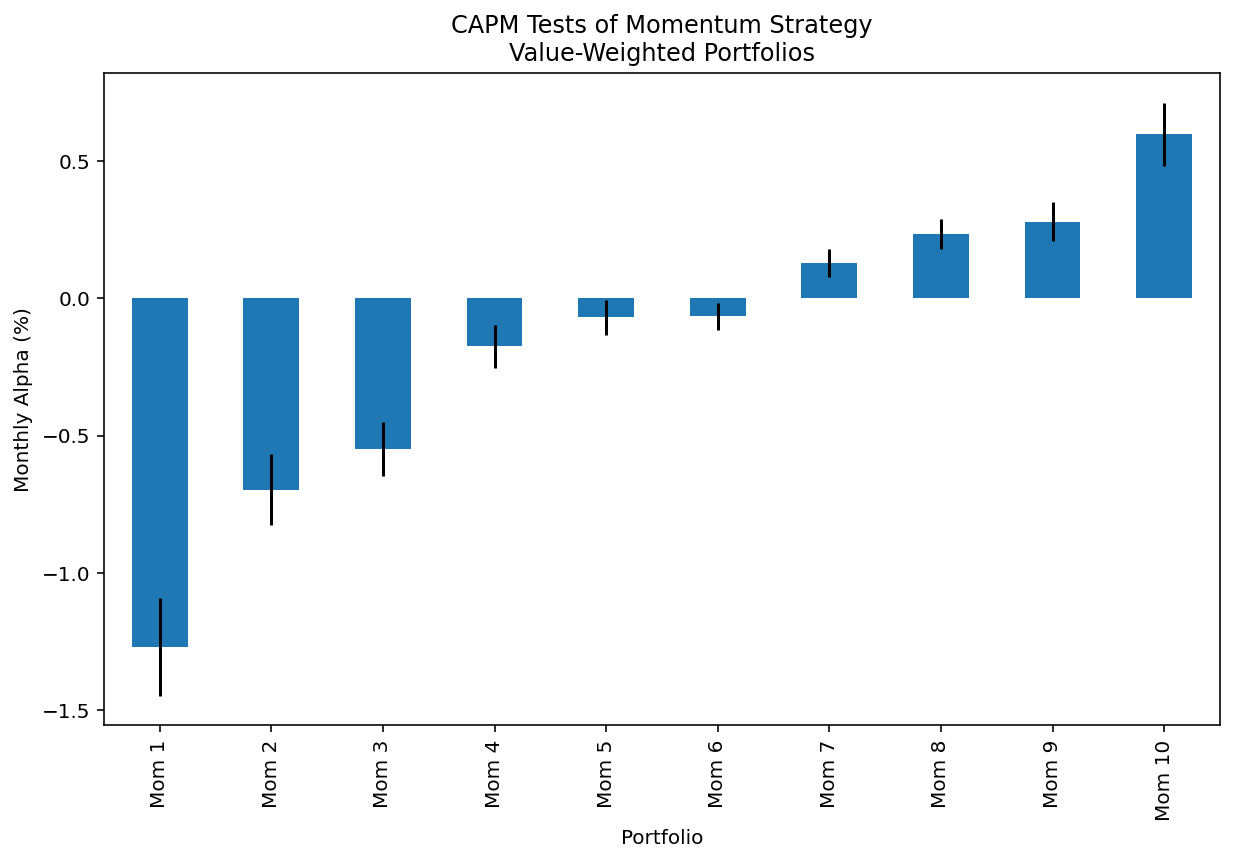

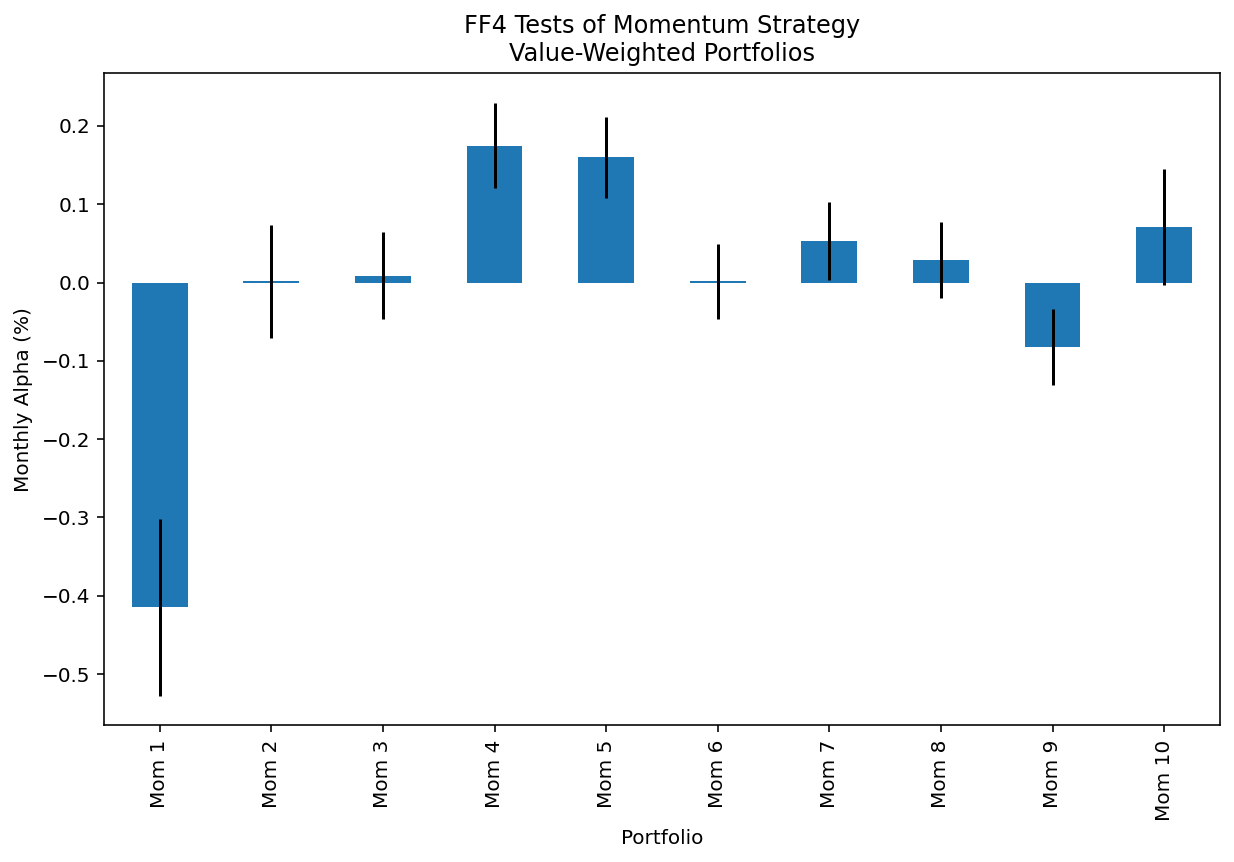

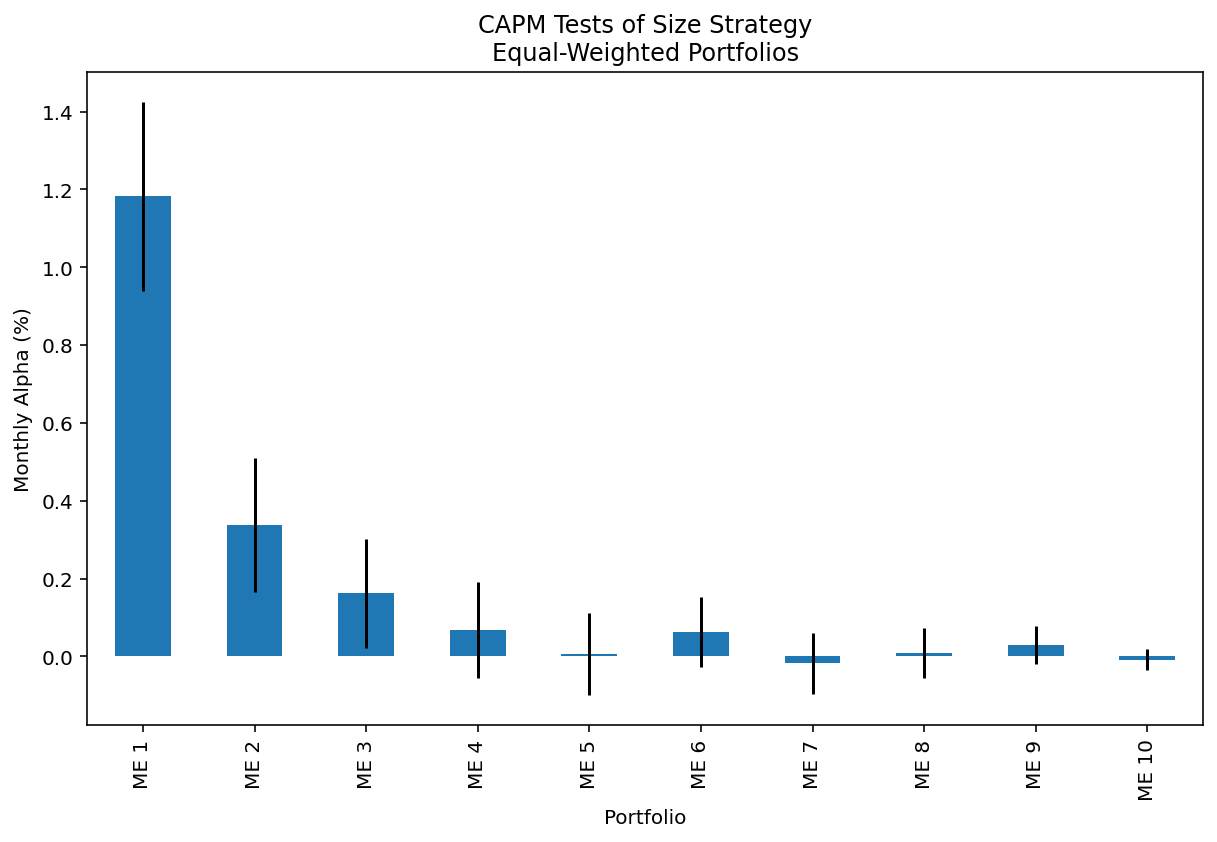

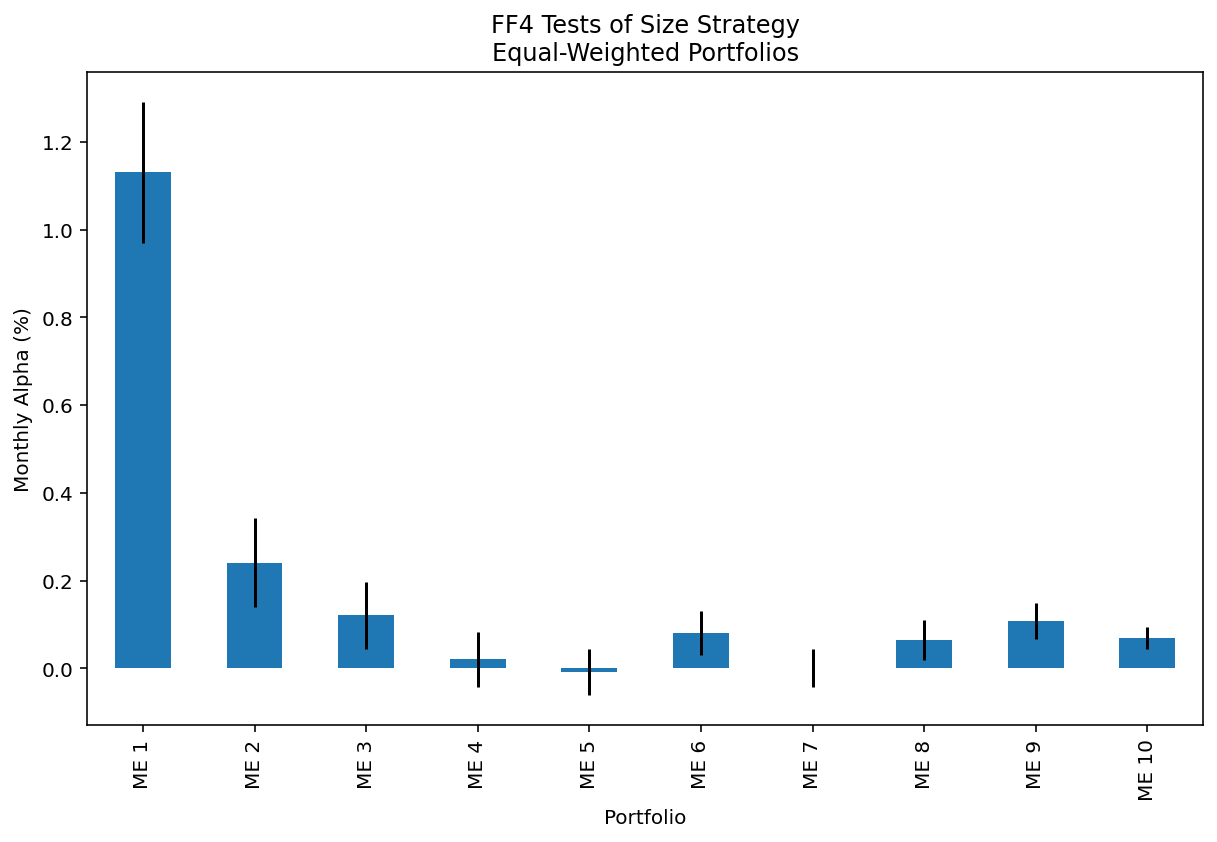

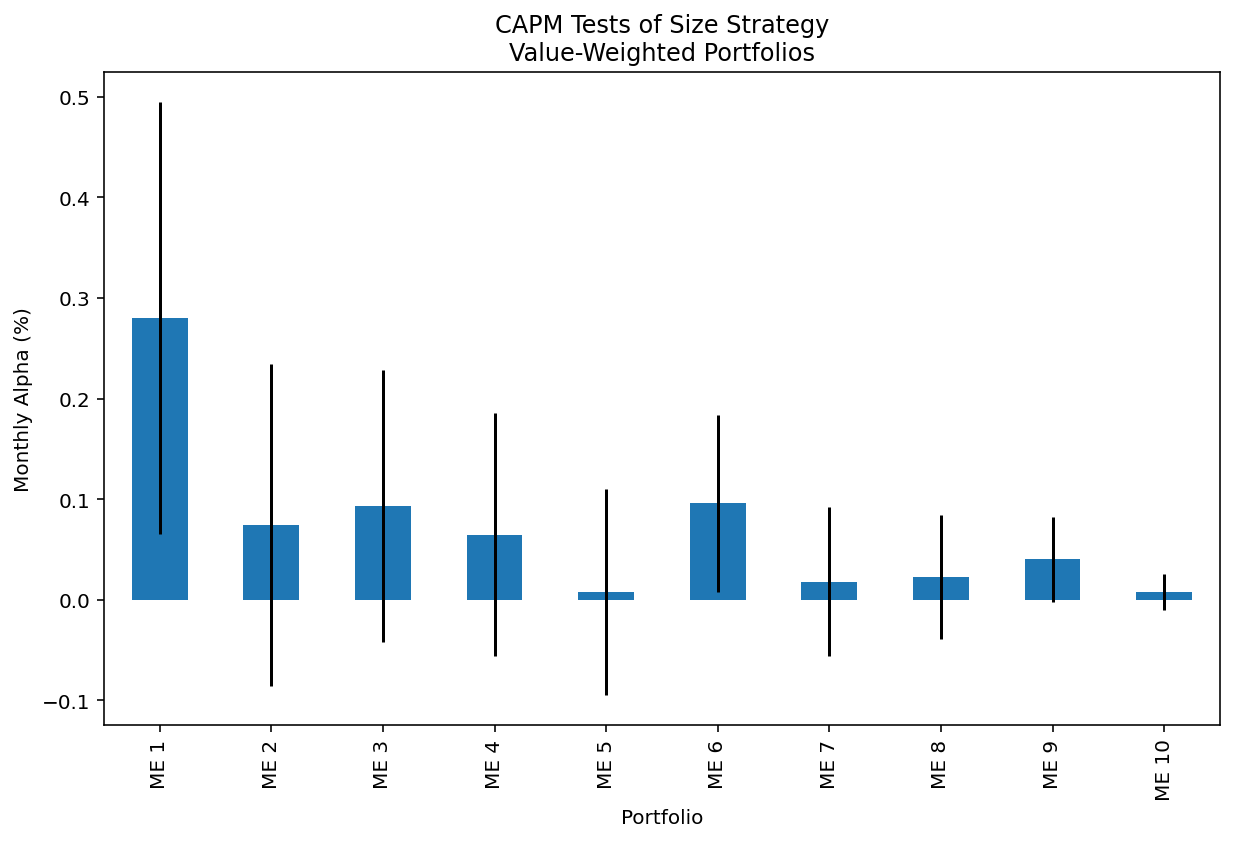

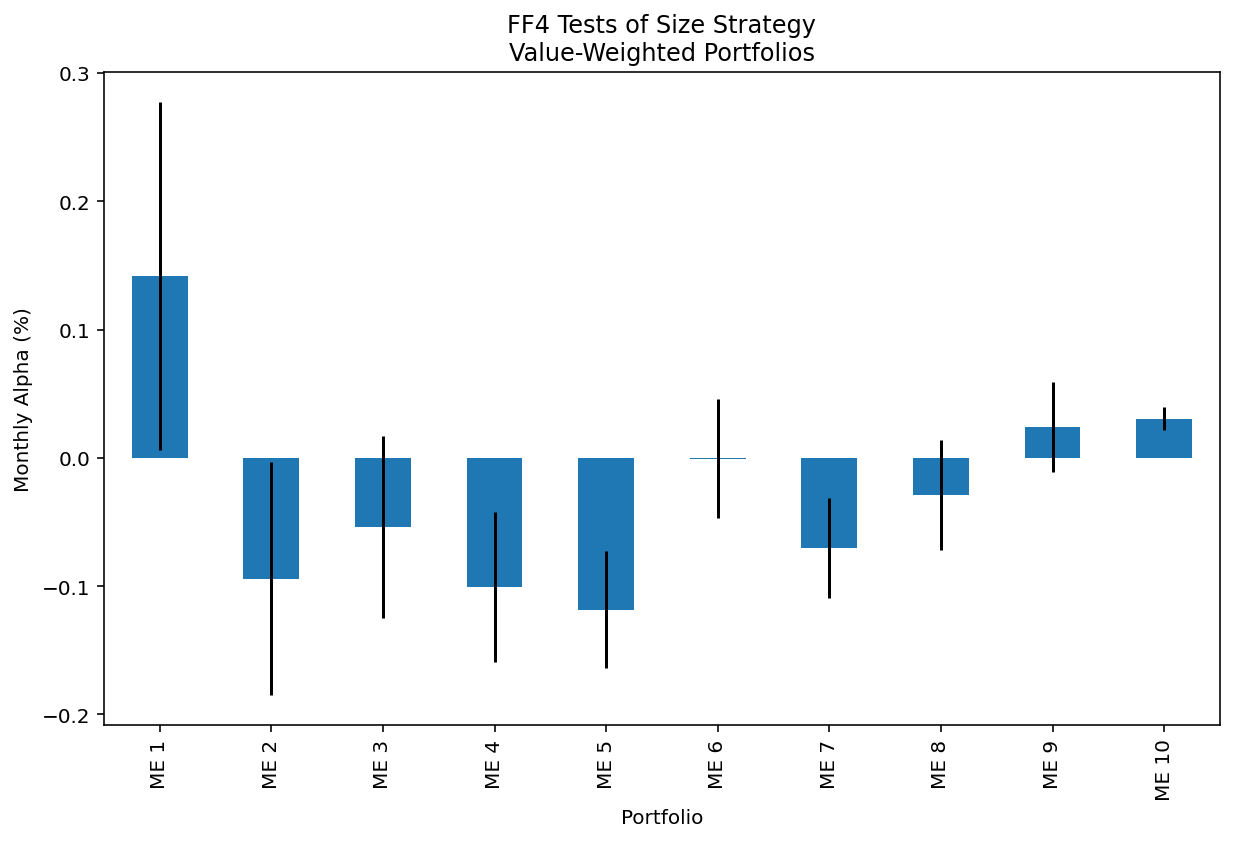

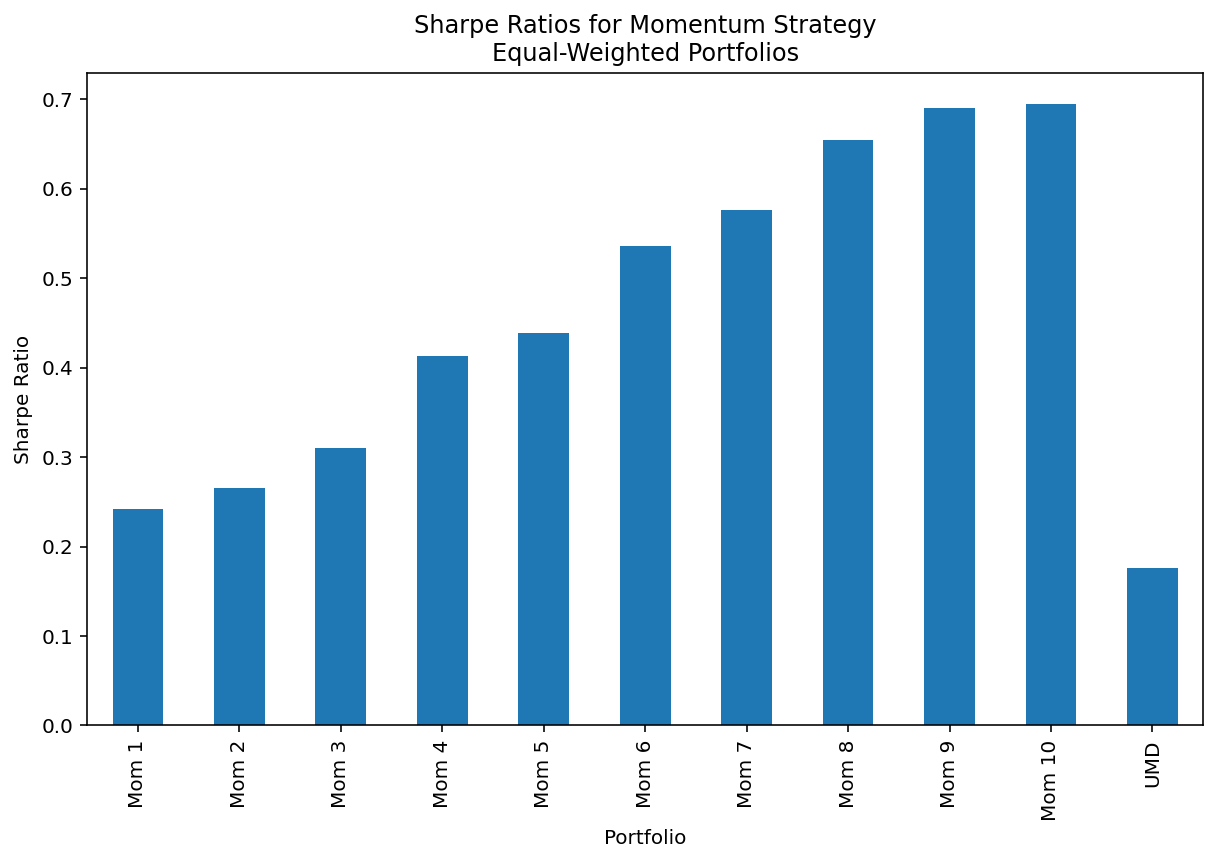

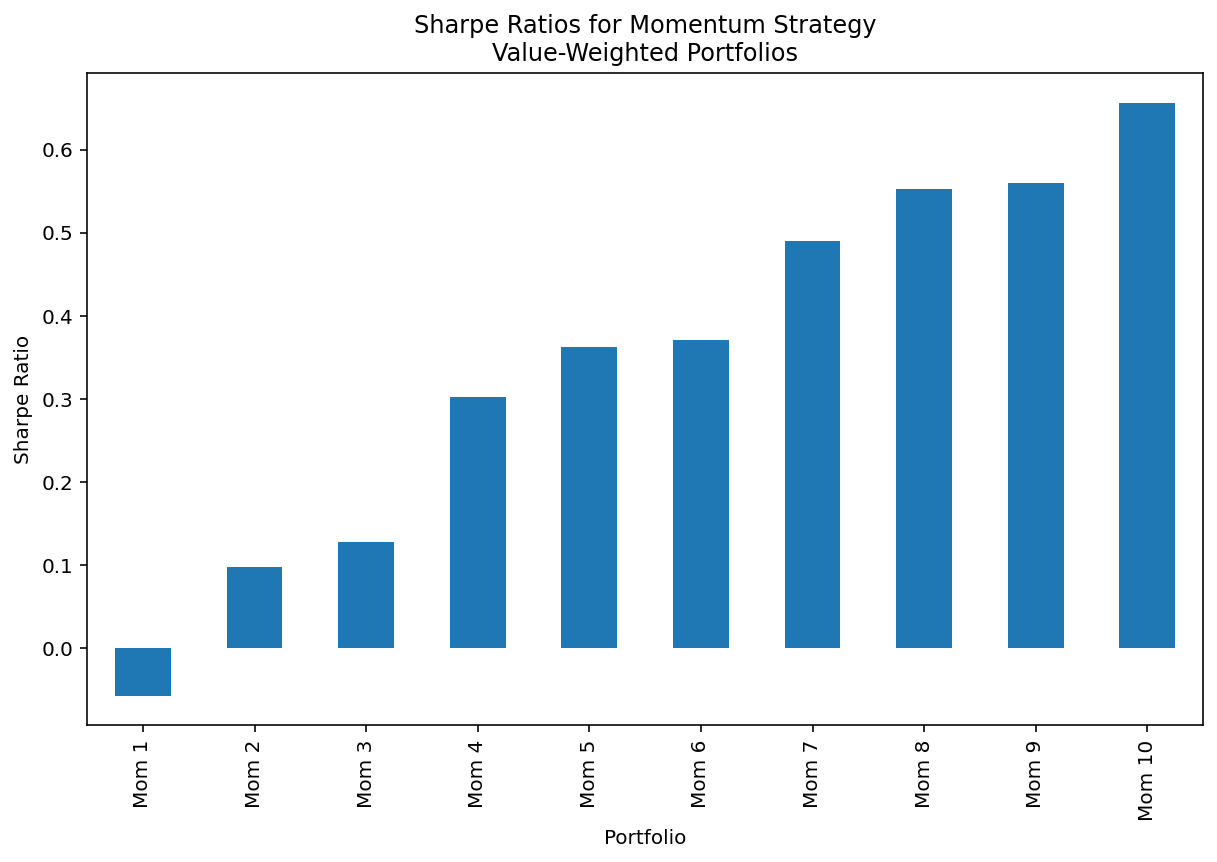

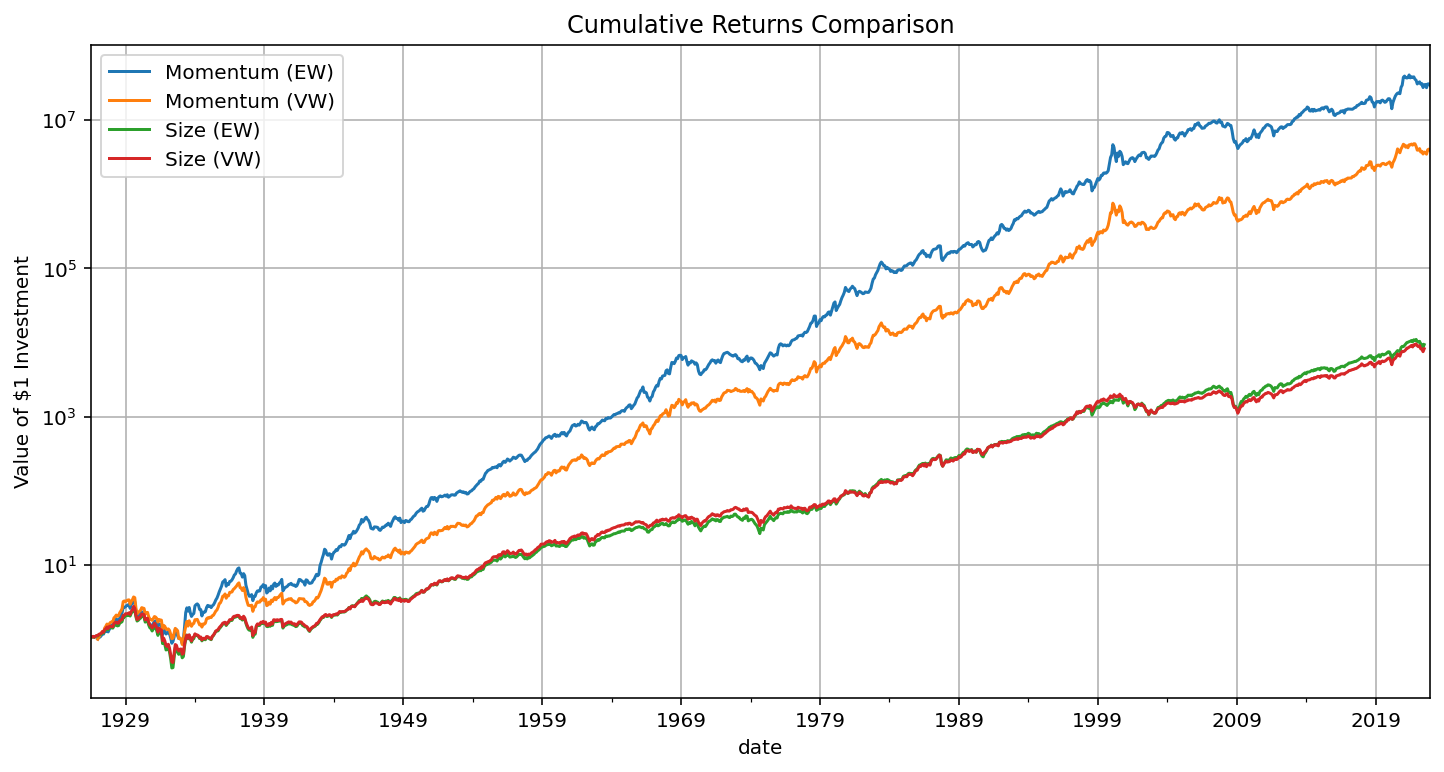

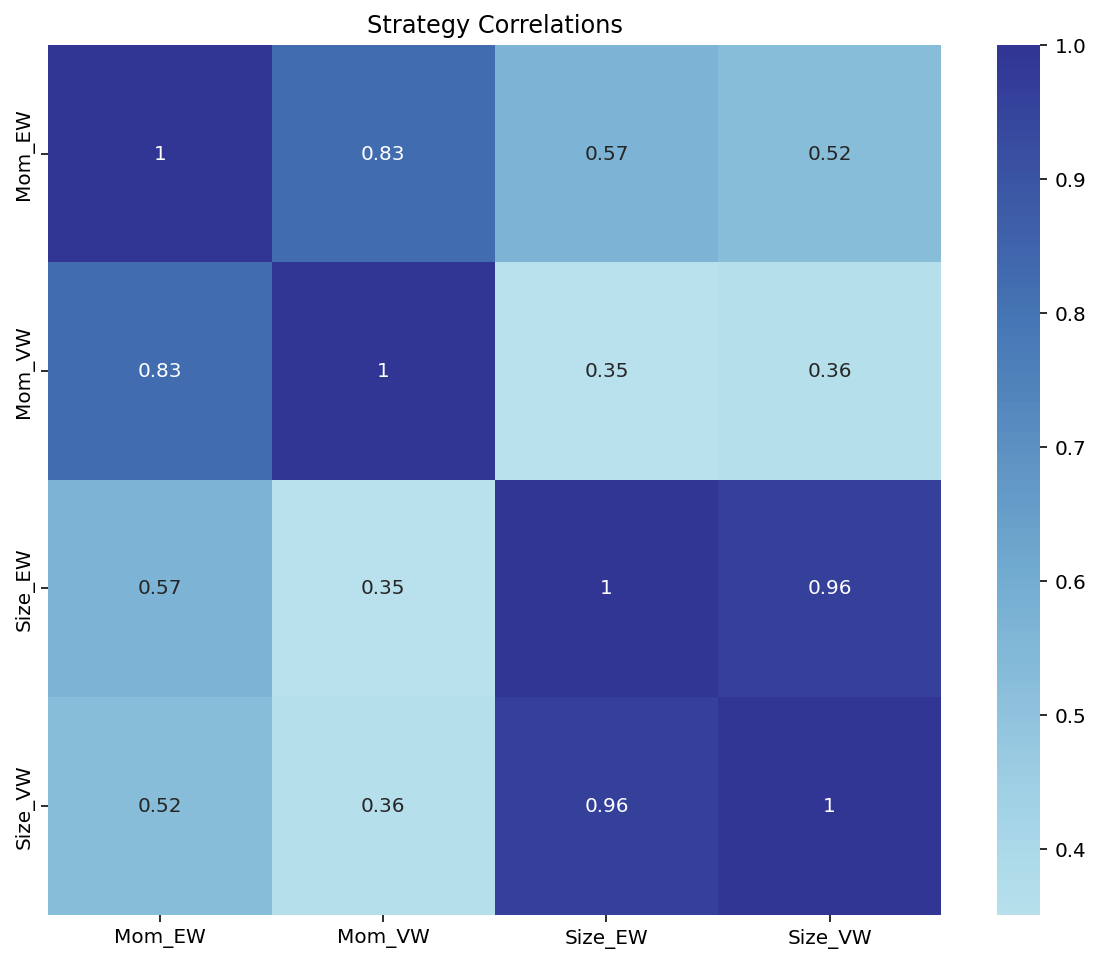

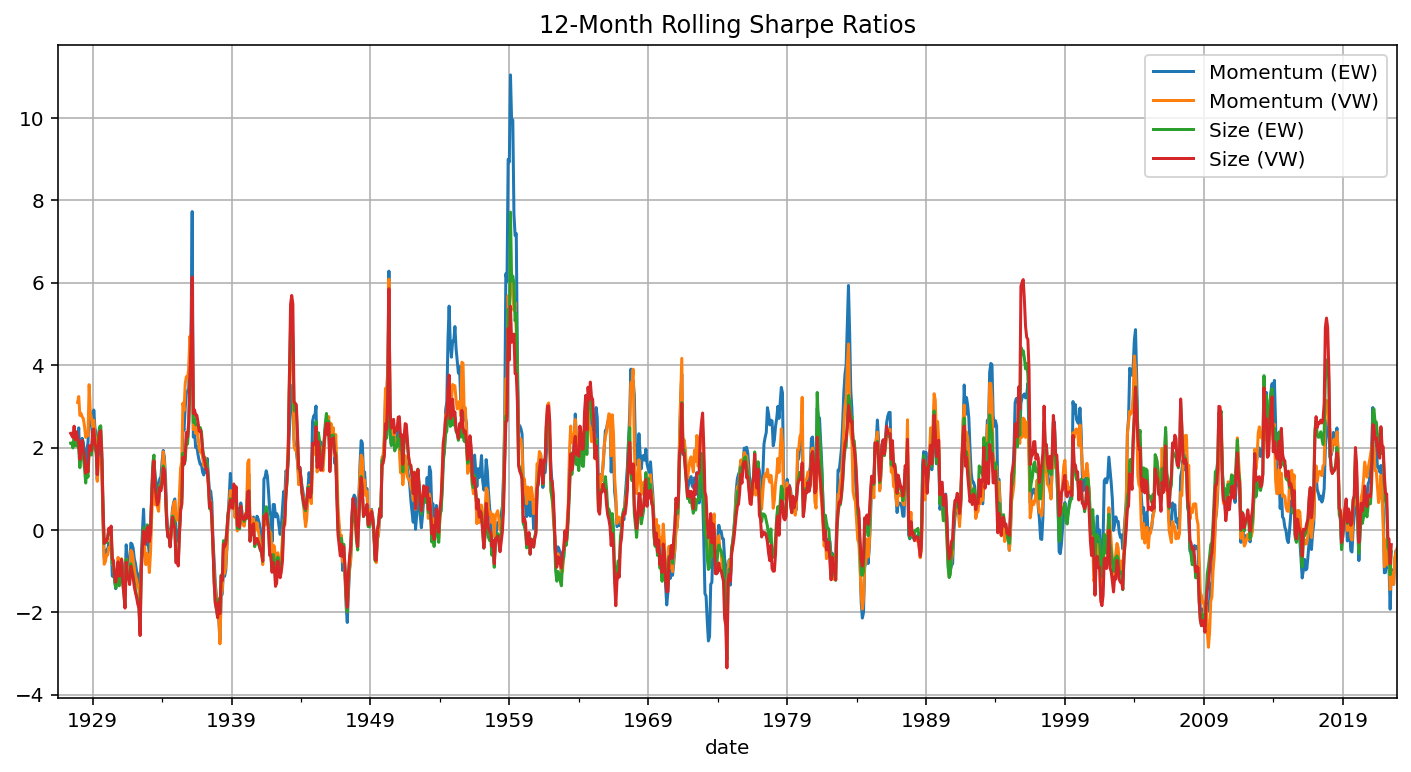

In [4]:
def demonstrate_analysis_usage():
    # Run the analysis
    results = analyze_investment_strategies('crsp.csv')
    
    # 1. Basic Data Access
    # Access momentum strategy data
    mom_ew = results['data']['momentum_equal_weighted']
    mom_vw = results['data']['momentum_value_weighted']
    
    # Access size strategy data
    size_ew = results['data']['size_equal_weighted']
    size_vw = results['data']['size_value_weighted']
    
    # 2. Working with Analysis Results
    # Get CAPM results for equal-weighted momentum strategy
    mom_ew_capm = results['analysis']['mom_ew_capm']
    
    # Print summary statistics
    print("\nMomentum Strategy CAPM Analysis:")
    print("--------------------------------")
    print(f"Alpha (Portfolio 10): {mom_ew_capm.loc['Mom 10'].loc['Coef']['Intercept']:.4f}%")
    print(f"Alpha t-stat: {mom_ew_capm.loc['Mom 10'].loc['Coef']['Intercept'] / mom_ew_capm.loc['Mom 10'].loc['SE']['Intercept']:.2f}")
    
    # 3. Creating Custom Visualizations
    
    # 3.1 Compare returns across strategies
    fig, ax = plt.subplots(figsize=(12, 6))
    strategies = {
        'Momentum (EW)': mom_ew['Mom 10'],
        'Momentum (VW)': mom_vw['Mom 10'],
        'Size (EW)': size_ew['ME 10'],
        'Size (VW)': size_vw['ME 10']
    }
    
    returns_comparison = pd.DataFrame(strategies).add(1).cumprod()
    returns_comparison.plot(ax=ax)
    plt.title('Cumulative Returns Comparison')
    plt.ylabel('Value of $1 Investment')
    plt.yscale('log')
    plt.grid(True)
    
    # 3.2 Create a heatmap of correlations
    fig, ax = plt.subplots(figsize=(10, 8))
    strategy_returns = pd.DataFrame({
        'Mom_EW': mom_ew['UMD'],
        'Mom_VW': mom_vw['Mom 10'] - mom_vw['Mom 1'],
        'Size_EW': size_ew['ME 10'] - size_ew['ME 1'],
        'Size_VW': size_vw['ME 10'] - size_vw['ME 1']
    })
    
    sns.heatmap(strategy_returns.corr(), 
                annot=True, 
                cmap='RdYlBu', 
                center=0,
                ax=ax)
    plt.title('Strategy Correlations')
    
    # 4. Performance Analysis
    
    # 4.1 Calculate rolling Sharpe ratios
    def rolling_sharpe(returns, rf_rate, window=12):
        excess_returns = returns - rf_rate
        return (excess_returns.rolling(window).mean() / 
                excess_returns.rolling(window).std() * 
                np.sqrt(12))
    
    # Get RF rate from results (you'll need to add this to the main function's output)
    rf_rate = 0.02/12  # Example risk-free rate, adjust as needed
    
    rolling_sharpes = pd.DataFrame({
        'Momentum (EW)': rolling_sharpe(mom_ew['Mom 10'], rf_rate),
        'Momentum (VW)': rolling_sharpe(mom_vw['Mom 10'], rf_rate),
        'Size (EW)': rolling_sharpe(size_ew['ME 10'], rf_rate),
        'Size (VW)': rolling_sharpe(size_vw['ME 10'], rf_rate)
    })
    
    # Plot rolling Sharpe ratios
    fig, ax = plt.subplots(figsize=(12, 6))
    rolling_sharpes.plot(ax=ax)
    plt.title('12-Month Rolling Sharpe Ratios')
    plt.grid(True)
    
    # 5. Save Results
    
    # 5.1 Save analysis results to Excel
    with pd.ExcelWriter('investment_analysis_results.xlsx') as writer:
        # Save raw returns
        mom_ew.to_excel(writer, sheet_name='Momentum_EW')
        mom_vw.to_excel(writer, sheet_name='Momentum_VW')
        size_ew.to_excel(writer, sheet_name='Size_EW')
        size_vw.to_excel(writer, sheet_name='Size_VW')
        
        # Save analysis results
        pd.DataFrame(mom_ew_capm).to_excel(writer, sheet_name='CAPM_Analysis')
        
        # Save correlation matrix
        strategy_returns.corr().to_excel(writer, sheet_name='Correlations')
    
    # 5.2 Save plots
    output_dir = Path('analysis_plots')
    output_dir.mkdir(exist_ok=True)
    
    for name, fig in results['plots'].items():
        fig.savefig(output_dir / f'{name}.png', dpi=300, bbox_inches='tight')
    
    # 6. Analysis of Specific Time Periods
    
    # 6.1 Crisis period analysis (e.g., 2008 Financial Crisis)
    crisis_period = slice('2008-01', '2009-12')
    crisis_returns = pd.DataFrame({
        'Momentum (EW)': mom_ew['Mom 10'][crisis_period],
        'Size (EW)': size_ew['ME 10'][crisis_period]
    })
    
    print("\nCrisis Period Analysis (2008-2009):")
    print("-----------------------------------")
    print(crisis_returns.describe())
    
    # 6.2 Calculate drawdowns
    def calculate_drawdowns(returns):
        cum_returns = (1 + returns).cumprod()
        running_max = cum_returns.cummax()
        drawdowns = cum_returns / running_max - 1
        return drawdowns
    
    strategy_drawdowns = pd.DataFrame({
        'Momentum (EW)': calculate_drawdowns(mom_ew['Mom 10']),
        'Size (EW)': calculate_drawdowns(size_ew['ME 10'])
    })
    
    print("\nMaximum Drawdowns:")
    print("-----------------")
    print(strategy_drawdowns.min())
    
    return {
        'returns_comparison': returns_comparison,
        'strategy_returns': strategy_returns,
        'rolling_sharpes': rolling_sharpes,
        'strategy_drawdowns': strategy_drawdowns
    }

# Example execution
if __name__ == "__main__":
    additional_results = demonstrate_analysis_usage()
    
    # Display some key metrics
    print("\nSummary Statistics:")
    print("-----------------")
    print(additional_results['strategy_returns'].describe())
    
    # Show plots
    plt.show()